In [37]:
pip install "tensorflow>=2.0.0"

Note: you may need to restart the kernel to use updated packages.


In [38]:
pip install --upgrade tensorflow-hub

In [39]:
import zipfile
import os
import datetime
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.models import load_model

In [40]:
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [41]:
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [42]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")


Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [43]:
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback


In [44]:
def download_model(model_url, model_name, save_dir="models"):
    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, model_name + ".h5")
    
    if not os.path.exists(model_path):
        print(f"Downloading {model_name}...")
        urllib.request.urlretrieve(model_url, model_path)
        print(f"Saved {model_name} to {model_path}")
    else:
        print(f"{model_name} already exists at {model_path}")
    
    return model_path

In [45]:

resnet_url = "https://kaggle.com/models/google/resnet-v2/TensorFlow2/50-feature-vector/1"

efficientnet_url = "https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-feature-vector/1"


In [46]:
def create_model(model_url, num_classes=10):
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, 
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) 

 
  model = tf.keras.Sequential([
    feature_extractor_layer, 
    layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model

In [47]:
import tensorflow as tf
import tensorflow_hub as hub

num_classes = 10  

class KerasLayerWrapper(tf.keras.layers.Layer):
    def __init__(self, model_url, **kwargs):
        super(KerasLayerWrapper, self).__init__(**kwargs)
        self.model = hub.KerasLayer(model_url, trainable=False)
        
    def call(self, inputs):
        return self.model(inputs)


m = tf.keras.Sequential([
    KerasLayerWrapper("https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-feature-vector/1"),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

m.build([None, 224, 224, 3])


In [48]:
m.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [49]:
val_loss, val_acc = m.evaluate(test_data, steps=len(test_data))
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")


C:\Users\kaust\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 30s 364ms/step - accuracy: 0.1010 - loss: 2.4495
Validation Loss: 2.448714017868042, Validation Accuracy: 0.10199999809265137


In [50]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',    
    patience=3,            
    restore_best_weights=True  
)

In [61]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


EfficientNetB0_history = m.fit(
    train_data_10_percent,
    epochs=20,
    validation_data=test_data,
    callbacks=[
        create_tensorboard_callback(dir_name="tensorflow_hub", experiment_name="EfficientNetB0"),
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
    ]
)


if 'val_loss' in EfficientNetB0_history.history:
    print("Validation Loss:", EfficientNetB0_history.history['val_loss'])
else:
    print("Validation Loss key not found in history.")

if 'val_accuracy' in EfficientNetB0_history.history:
    print("Validation Accuracy:", EfficientNetB0_history.history['val_accuracy'])
else:
    print("Validation Accuracy key not found in history.")


Saving TensorBoard log files to: tensorflow_hub/EfficientNetB0/20240814-135906
Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8682 - loss: 0.6044 - val_accuracy: 0.8564 - val_loss: 0.6063 - learning_rate: 0.0010
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8990 - loss: 0.5267 - val_accuracy: 0.8640 - val_loss: 0.5508 - learning_rate: 0.0010
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9213 - loss: 0.4508 - val_accuracy: 0.8704 - val_loss: 0.5186 - learning_rate: 0.0010
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9203 - loss: 0.3944 - val_accuracy: 0.8748 - val_loss: 0.4905 - learning_rate: 0.0010
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9423 - loss: 0.3437 - val_accuracy: 0.8784 - val_loss: 0.4724 - learning_rate: 0.0010
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9574 - loss: 0.3051 - val_accuracy: 0.8784 - val_loss: 0.4562 - learning_rate: 0.0010
Epoch 7/20
24/24 ━━━━

In [63]:
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history.get('val_loss', None)
    accuracy = history.history['accuracy']
    val_accuracy = history.history.get('val_accuracy', None)
    epochs = range(len(loss))

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss, label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, accuracy, label='Training Accuracy')
    if val_accuracy:
        plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


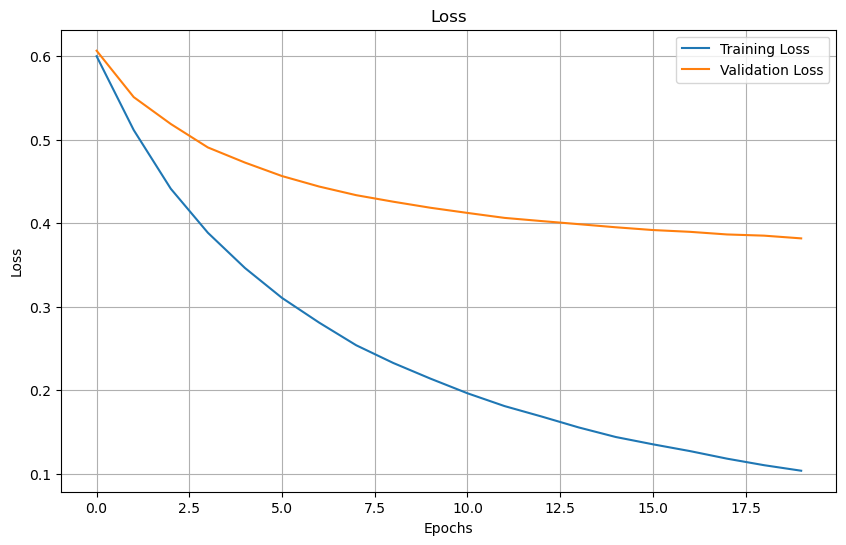

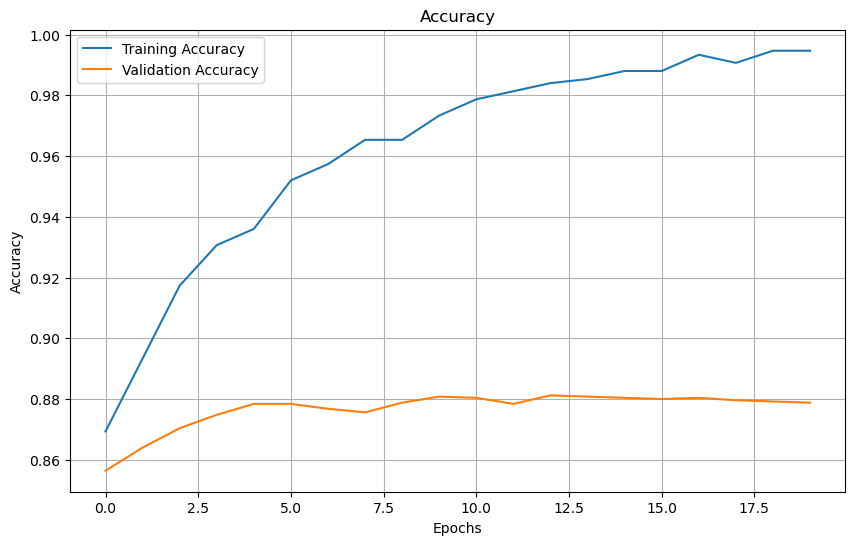

In [65]:
plot_loss_curves(EfficientNetB0_history)

In [67]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (512, 512, 3)
Image shape: (512, 382, 3)
Image shape: (512, 512, 3)
Image shape: (512, 512, 3)
Image shape: (512, 512, 3)
Image shape: (384, 512, 3)
Image shape: (512, 512, 3)
Image shape: (384, 512, 3)
Image shape: (354, 512, 3)
Image shape: (512, 289, 3)


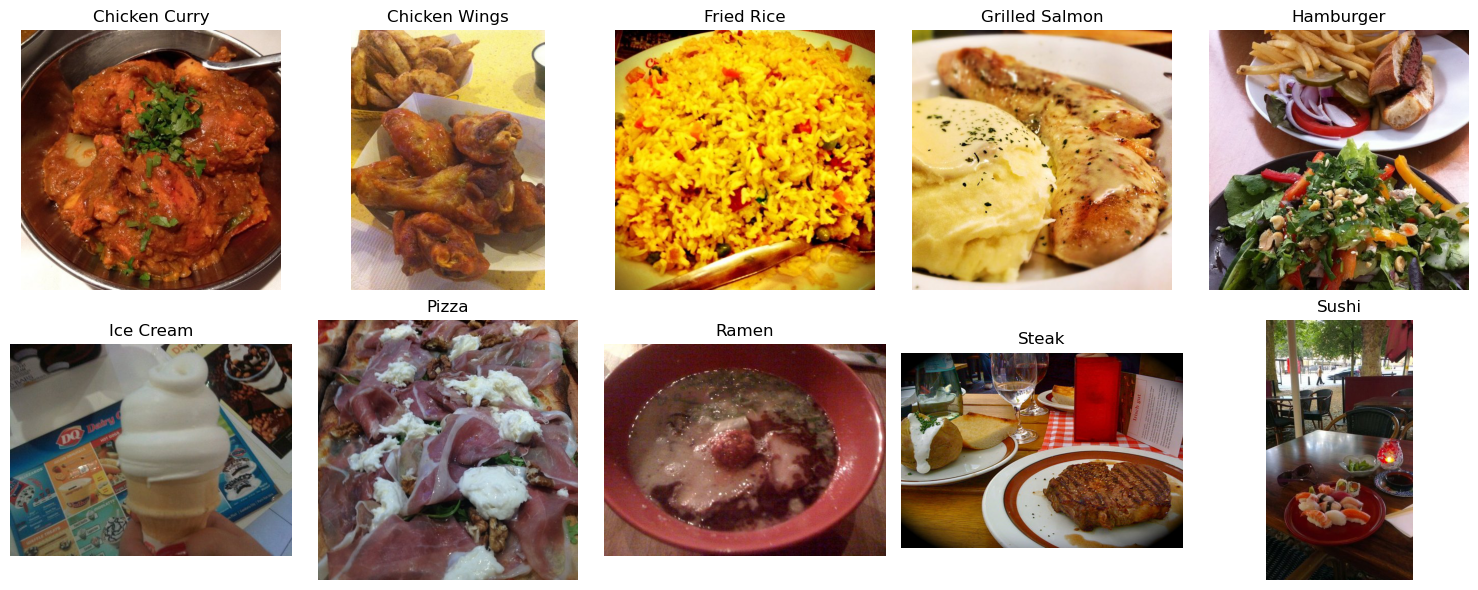

In [69]:
plt.figure(figsize=(15, 6))

plt.subplot(2, 5, 1)
view_random_image("10_food_classes_10_percent/train/", "chicken_curry")
plt.title("Chicken Curry")

plt.subplot(2, 5, 2)
view_random_image("10_food_classes_10_percent/train/", "chicken_wings")
plt.title("Chicken Wings")

plt.subplot(2, 5, 3)
view_random_image("10_food_classes_10_percent/train/", "fried_rice")
plt.title("Fried Rice")

plt.subplot(2, 5, 4)
view_random_image("10_food_classes_10_percent/train/", "grilled_salmon")
plt.title("Grilled Salmon")

plt.subplot(2, 5, 5)
view_random_image("10_food_classes_10_percent/train/", "hamburger")
plt.title("Hamburger")

plt.subplot(2, 5, 6)
view_random_image("10_food_classes_10_percent/train/", "ice_cream")
plt.title("Ice Cream")

plt.subplot(2, 5, 7)
view_random_image("10_food_classes_10_percent/train/", "pizza")
plt.title("Pizza")

plt.subplot(2, 5, 8)
view_random_image("10_food_classes_10_percent/train/", "ramen")
plt.title("Ramen")

plt.subplot(2, 5, 9)
view_random_image("10_food_classes_10_percent/train/", "steak")
plt.title("Steak")

plt.subplot(2, 5, 10)
view_random_image("10_food_classes_10_percent/train/", "sushi")
plt.title("Sushi")

plt.tight_layout()
plt.show()